In [60]:
#This program fits the O-PPAC data onto a FCNN model
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, metrics, Model
from tensorflow.keras.callbacks import Callback
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import normalize
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
import numpy as np
from numpy import *
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import h5py
import datetime

In [61]:
dataset = h5py.File('simu_HDF_thistimeforReal.h5', 'r') #load data
num_diodes = dataset['Num_diodes'][...] #separate the data into each key within the data file
x_pos = (dataset['Xpos'][...])/100
y_pos = (dataset['Ypos'][...])/100
histgrid = dataset['histgrid'][...]
histgrid = histgrid[:-10,:,:] #redefine the shape and size of histgrid by removing the last 10 events
output = np.vstack((x_pos,y_pos)) #define new, single variable for x and y position
output = np.transpose(output) #original definition was sideways, so we transposed it

where_are_NaNs = isnan(histgrid) #removes any NaN values within histgrid; shouldn't be a problem with "values" removed
histgrid[where_are_NaNs] = 0

print(histgrid.shape)

dataset.close()

(991, 342, 132)


In [81]:
def data_compile(histdata):
    data = []  #creates empty arrays for data and labels
    labels = []
    for i in range(histdata.shape[1]):
        for j in range(0,histdata.shape[0]):
            data.append(histdata[j,i,:]) #puts histgrid data inside of "data"
            labels.append(output[i]) #puts x,y _pos into "labels"
    return(np.array(data),np.array(labels))

all_data, all_labels = data_compile(histgrid)

#to make sure everything is the correct shape
print(all_data.shape)
print(all_labels.shape)

(338922, 132)
(338922, 2)


In [82]:
#normalizes all data to unit vectors
all_data = normalize(all_data,axis = 1)
print(np.max(all_data))

0.8395246220687987


In [83]:
#define all_labels and all_data as df's to better view rows and add column
all_labels = pd.DataFrame(all_labels)
all_data = pd.DataFrame(all_data)
all_data["sum"] = np.sum(all_data, axis = 1) #column added to find rows with only 0

#confirming number of initial entries
print(len(all_labels))
print(len(all_data))

#find all the locations in all_data (by index) where the only values are 0 across the diodes
remove_labels = list(all_data[all_data["sum"] == 0].index)
print(len(remove_labels))

#added these to ensure I have unshuffled versions of the data and labels for finding locations with larger error
unshuf_labels = all_labels.drop(all_labels.index[remove_labels])
unshuf_data = all_data[all_data["sum"] != 0]

#lets all_labels and all_data start with the same indices and values as their unshuffled counterparts
all_labels = unshuf_labels
unshuf_labels = unshuf_labels.to_numpy() #dfs are hard to graph with, so I converted to np.arrays for future use
all_data = unshuf_data
unshuf_data = unshuf_data.to_numpy()

#confirm new number of entries (should be len(remove_labels) less than the intital value)
print(len(all_labels))
print(len(all_data))

#must remove the sum column before using in FCNN; otherwise it will treat it as a data point 
del all_data['sum']

338922
338922
286
338636
338636


In [84]:
train_data, test_data, train_labels, test_labels = train_test_split(all_data, all_labels, test_size=0.2,shuffle=True)
#splits training and test data for the FCNN; 20% set aside for testing

In [85]:
print(train_data.ndim)
print(train_data.shape)
print(train_data[0])

2
(270908, 132)
205154    0.0
327739    0.0
219032    0.0
178461    0.0
308329    0.0
         ... 
81520     0.0
210414    0.0
52922     0.0
338273    0.0
210042    0.0
Name: 0, Length: 270908, dtype: float64


In [86]:
#early stopping mechanism; can increase amount of time before stopping by increasing patience
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [87]:
#Fully connected neural network
#the "layers" are the dense hidden layers which are fully connected
#first number changes the nodes, 2nd is the activation function, (first line has number of inputs as well)

FCNN_model = tf.keras.Sequential()
FCNN_model.add(layers.Dense(256, activation='relu', input_shape = [132]))
FCNN_model.add(layers.Dense(256, activation = 'relu'))
#FCNN_model.add(layers.Dense(128, activation = 'relu'))
#FCNN_model.add(layers.Dense(128, activation = 'relu'))
#FCNN_model.add(layers.Dropout(0.2))
FCNN_model.add(layers.Dense(2, activation = 'linear'))

In [88]:
#compiles the FCNN and includes the learning rate as well
FCNN_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss = 'mse', 
              metrics=['mae', 'mse'])

In [89]:
FCNN_history = FCNN_model.fit(train_data, train_labels,
                    epochs=100,
                    batch_size = 32,
                    callbacks = [callback],
                    validation_split = 0.3 
                    )

Epoch 1/100
5927/5927 [==============================] - 23s 4ms/step - loss: 4.4656 - mae: 0.6876 - mse: 4.4656 - val_loss: 0.2225 - val_mae: 0.3695 - val_mse: 0.2225
Epoch 2/100
5927/5927 [==============================] - 18s 3ms/step - loss: 0.1850 - mae: 0.3280 - mse: 0.1850 - val_loss: 0.1268 - val_mae: 0.2787 - val_mse: 0.1268
Epoch 3/100
5927/5927 [==============================] - 19s 3ms/step - loss: 0.1175 - mae: 0.2641 - mse: 0.1175 - val_loss: 0.1157 - val_mae: 0.2703 - val_mse: 0.1157
Epoch 4/100
5927/5927 [==============================] - 16s 3ms/step - loss: 0.0830 - mae: 0.2227 - mse: 0.0830 - val_loss: 0.0659 - val_mae: 0.2028 - val_mse: 0.0659
Epoch 5/100
5927/5927 [==============================] - 19s 3ms/step - loss: 0.0689 - mae: 0.2018 - mse: 0.0689 - val_loss: 0.0533 - val_mae: 0.1821 - val_mse: 0.0533
Epoch 6/100
5927/5927 [==============================] - 17s 3ms/step - loss: 0.0569 - mae: 0.1834 - mse: 0.0569 - val_loss: 0.0464 - val_mae: 0.1717 - val_mse:

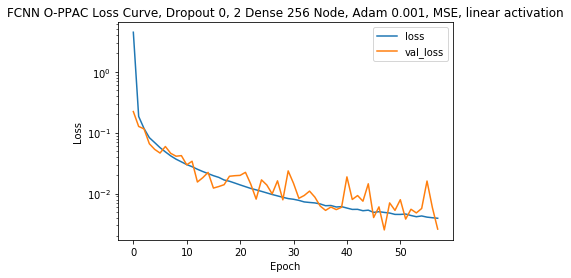

In [90]:
#loss plot of training and test data
plt.plot(FCNN_history.history['loss'], label='loss')
plt.plot(FCNN_history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.yscale('log')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title("FCNN O-PPAC Loss Curve, Dropout 0, 2 Dense 256 Node, Adam 0.001, MSE, linear activation")
plt.show()

In [91]:
#separation of 'result' values (stats from test data)
result = FCNN_model.evaluate(test_data, test_labels, verbose=2)

2117/2117 - 3s - loss: 0.0027 - mae: 0.0383 - mse: 0.0027


In [92]:
#separation of 'prediction' values (training data)
predictions = FCNN_model.predict(test_data)

In [93]:
#separates x and y predicted values so there can be separate graphs for each
x_pred = predictions[:,0]
y_pred = predictions[:,1]


x_test1 = test_labels[0]
y_test1 = test_labels[1]

#converts to np.arrays for graphing
x_test = np.array(x_test1)
y_test = np.array(y_test1)


x_test[0]
y_test[0]

4.0

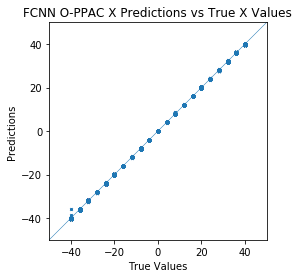

In [94]:
#graph showing the accuracy of model by comparing predicted and true x values
#should be as close to the diagonal as possible
new_x_labels = []
for i in range(x_test.shape[0]):
    new_x_labels.append([x_test[i]])
np.array(new_x_labels)
new_x_labels[2]

a = plt.axes(aspect='equal')

plt.scatter(new_x_labels, x_pred, s=6, marker = "x")
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [-50, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims, linewidth = .5)
plt.title("FCNN O-PPAC X Predictions vs True X Values")
plt.show()

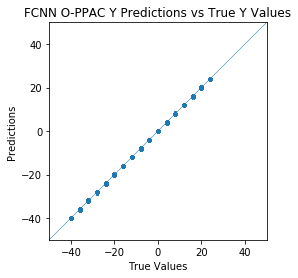

In [95]:
#graph showing the accuracy of model by comparing predicted and true y values
#should be as close to the diagonal as possible
new_y_labels = []
for i in range(y_test.shape[0]):
    new_y_labels.append([y_test[i]])
np.array(new_y_labels)
new_y_labels[2]

a = plt.axes(aspect='equal')
plt.scatter(new_y_labels, y_pred, s=6, marker = "x")
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [-50, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims, linewidth = .5)
plt.title("FCNN O-PPAC Y Predictions vs True Y Values")
plt.show()

In [96]:
#to find the locations of largest error within my predicted x values
x_error = []

#reads through every data point from the FCNN and compares to the true value by finding the difference between the two
for i in range(x_pred.shape[0]):
    x_error_test = x_pred[i] - x_test[i]
    x_error.append(x_error_test)

#this takes all the points with error greater than 1 mm
#one can then see the number of points with large error + use lower code to see where/what they are
xerror_list = [i for i in x_error if abs(i) >= 1]
xerror_list.sort(reverse = True)
print(len(xerror_list))
print(xerror_list)

2
[4.306068420410156, 1.2007331848144531]


In [98]:
#in "bad value" plug in x error value (from above) to find the index for x_pos and y_pos
bad_value = 4.306068420410156
x_locat = np.where(x_pos == (np.array(x_test[x_error.index(bad_value)])))
y_locat = np.where(y_pos == (np.array(y_test[x_error.index(bad_value)])))

print(np.intersect1d(x_locat, y_locat))

[121]


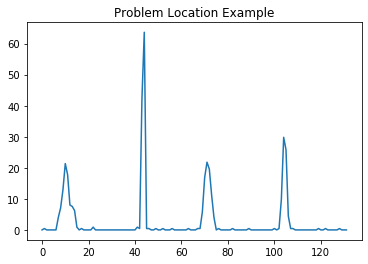

In [99]:
#graph the location of areas with larger x-error; uses unshuffled data from above
bad_xvalue = 4.306068420410156
x_test_locat = x_error.index(bad_xvalue)

plt.title('Problem Location Example')
plt.plot(unshuf_data[x_test_locat][:-1]*100)
plt.show()

In [100]:
#to find the locations of largest error within my predicted y values (same as the x code above but specific to y)
y_error = []

for i in range(y_pred.shape[0]):
    y_error_test = y_pred[i] - y_test[i]
    y_error.append(y_error_test)

yerror_list = [i for i in y_error if abs(i) >= 1]
yerror_list.sort(reverse = True)
print(len(yerror_list))
print(yerror_list)

1
[-1.099721908569336]


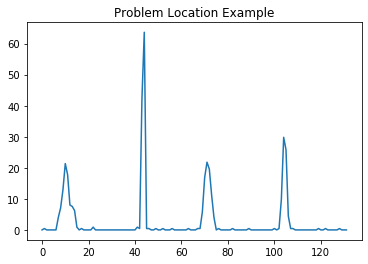

In [101]:
#graph the location of areas with larger error (bad_yvalue must come from y-prediction)
bad_yvalue = -1.099721908569336
y_test_locat = y_error.index(bad_yvalue)

plt.title('Problem Location Example')
plt.plot(unshuf_data[y_test_locat][:-1]*100)
plt.show()

In [102]:
#in "bad value" plug in y error value to find the index for x_pos and y_pos
bad_value = -1.099721908569336
x_locat = np.where(x_pos == (np.array(x_test[y_error.index(bad_value)])))
y_locat = np.where(y_pos == (np.array(y_test[y_error.index(bad_value)])))

print(np.intersect1d(x_locat, y_locat))

[121]


67726


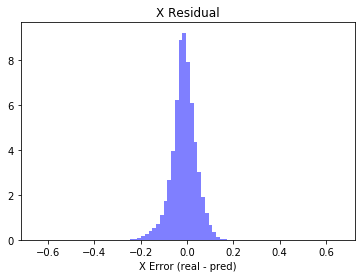

In [103]:
#residue plot of x-error from the model
x_error = []

for i in range(x_pred.shape[0]):
    x_error_test = x_pred[i] - x_test[i]
    x_error.append(x_error_test)

error_list_x = [i for i in x_error if abs(i) <= 1]
print(len(error_list_x))

num_bins_x = 81
# the histogram of the data
n, bins, patches = plt.hist(error_list_x, num_bins_x, density=1, facecolor='blue', alpha=0.5)

plt.xlabel('X Error (real - pred)')
plt.title(r'X Residual')
plt.show()

67727


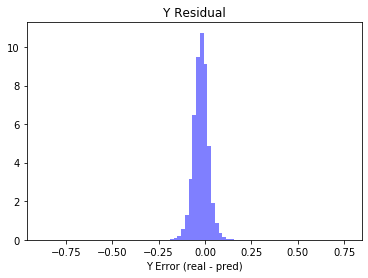

In [104]:
#residue plot of y-error from the model
y_error = []

for i in range(y_pred.shape[0]):
    y_error_test = y_pred[i] - y_test[i]
    y_error.append(y_error_test)

error_list_y = [i for i in y_error if abs(i) <= 1]
print(len(error_list_y))

num_bins_x = 81
# the histogram of the data
n, bins, patches = plt.hist(error_list_y, num_bins_x, density=1, facecolor='blue', alpha=0.5)

plt.xlabel('Y Error (real - pred)')
plt.title(r'Y Residual')
plt.show()